**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4


### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
%matplotlib inline

# Read in our vehicles and non-vehicles
cars = []
images = glob.iglob('./vehicles_non_vehicles/vehicles/**/*.png', recursive=True)
for image in images:
    cars.append(image)

notcars = []
images = glob.iglob('./vehicles_non_vehicles/non-vehicles/**/*.png', recursive=True)
for image in images:
    notcars.append(image)
    
print("# of car images: " + str(len(cars)))
print("# of notcar images: " + str(len(notcars)))

# of car images: 8792
# of notcar images: 8968


## Define HOG feature function

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                                  cells_per_block=(cell_per_block, cell_per_block), \
                                  visualise=True, feature_vector=False)
        #features = [] # Remove this line
        #hog_image = img # Remove this line
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                       cells_per_block=(cell_per_block, cell_per_block), \
                       visualise=False, feature_vector=feature_vec)
        #features = [] # Remove this line
        return features

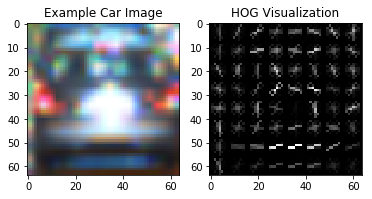

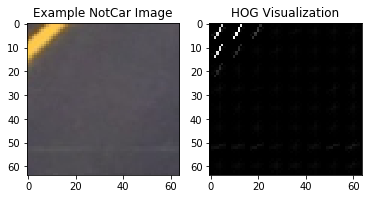

In [51]:
import re

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
#ind = 7584
#print(ind, cars[ind])
# Read in the image
#image = mpimg.imread(cars[ind])

original_img = cv2.imread(cars[ind])
b,g,r = cv2.split(original_img)
image = cv2.merge([r,g,b])

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

img_save_path = './output_images/car_HOG.jpg'
fig.savefig(img_save_path)

# Generate a random index to look at a notcar image
ind = np.random.randint(0, len(notcars))
#ind = 4516
#print(ind, notcars[ind])
# Read in the image
#image = mpimg.imread(cars[ind])

original_img = cv2.imread(notcars[ind])
b,g,r = cv2.split(original_img)
image = cv2.merge([r,g,b])

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example NotCar Image')


plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

img_save_path = './output_images/notcar_HOG.jpg'
fig.savefig(img_save_path)


### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and...



In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        
        image = cv2.imread(file)
        b,g,r = cv2.split(image)
        image = cv2.merge([r,g,b])
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


/Users/gq/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'] # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orients = [6, 9, 12]
pix_per_cells = [6, 8, 10, 12]
cell_per_blocks = [2, 3, 4]
hog_channels = [0, 1, 2, 'ALL'] # Can be 0, 1, 2, or "ALL"


for color_space in colorspaces:
    for orient in orients:
        for pix_per_cell in pix_per_cells:
            for cell_per_block in cell_per_blocks:
                for hog_channel in hog_channels:
                    t=time.time()
                    
                    print(color_space, orient, pix_per_cell, cell_per_block, hog_channel)
                    
                    if hog_channel=='ALL':
                        hog_channel = 'ALL'
                    else:
                        hog_channel = int(hog_channel)
                    
                    car_features = extract_features(cars, color_space=color_space, spatial_size=(32, 32),
                                                    hist_bins=32, orient=orient, 
                                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                                    hog_channel=hog_channel,
                                                    spatial_feat=False, hist_feat=False, hog_feat=True)

                    notcar_features = extract_features(notcars, color_space=color_space, spatial_size=(32, 32),
                                                       hist_bins=32, orient=orient, 
                                                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                                       hog_channel=hog_channel,
                                                       spatial_feat=False, hist_feat=False, hog_feat=True)

                    #car_features = extract_features(cars, color_space=colorspace, orient=orient, 
                    #                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    #                        hog_channel=hog_channel)
                    #notcar_features = extract_features(notcars, color_space=colorspace, orient=orient, 
                    #                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    #                        hog_channel=hog_channel)
                    t2 = time.time()
                    print(round(t2-t, 2), 'Seconds to extract HOG features...')
                    # Create an array stack of feature vectors
                    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                    # Fit a per-column scaler
                    X_scaler = StandardScaler().fit(X)
                    # Apply the scaler to X
                    scaled_X = X_scaler.transform(X)

                    # Define the labels vector
                    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


                    # Split up data into randomized training and test sets
                    rand_state = np.random.randint(0, 100)
                    X_train, X_test, y_train, y_test = train_test_split(
                        scaled_X, y, test_size=0.2, random_state=rand_state)

                    print('Using:',orient,'orientations',pix_per_cell,
                        'pixels per cell and', cell_per_block,'cells per block')
                    print('Feature vector length:', len(X_train[0]))
                    # Use a linear SVC 
                    svc = LinearSVC()
                    # Check the training time for the SVC
                    t=time.time()
                    svc.fit(X_train, y_train)
                    t2 = time.time()
                    print(round(t2-t, 2), 'Seconds to train SVC...')
                    # Check the score of the SVC
                    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
                    # Check the prediction time for a single sample
                    t=time.time()
                    n_predict = 10
                    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
                    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
                    t2 = time.time()
                    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
                    print('-------------------------------------------------------------------')

RGB 6 6 2 0


/Users/gq/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


28.85 Seconds to extract HOG features...
Using: 6 orientations 6 pixels per cell and 2 cells per block
Feature vector length: 1944
11.56 Seconds to train SVC...
Test Accuracy of SVC =  0.9248
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  1.  0.  1.  1.]
0.00194 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 6 6 2 1
27.74 Seconds to extract HOG features...
Using: 6 orientations 6 pixels per cell and 2 cells per block
Feature vector length: 1944
9.04 Seconds to train SVC...
Test Accuracy of SVC =  0.9268
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]
0.00188 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 6 6 2 2
27.8 Seconds to extract HOG features...
Using: 6 orientations 6 pixels per cell and 2 cells per block
Feature vector 

51.59 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 5832
22.02 Seconds to train SVC...
Test Accuracy of SVC =  0.9595
My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  1.]
0.00186 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 6 8 4 0
18.25 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 2400
17.57 Seconds to train SVC...
Test Accuracy of SVC =  0.9434
My SVC predicts:  [ 1.  0.  1.  1.  1.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
0.00393 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 6 8 4 1
18.22 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 4 cells per block
Feature vecto

16.08 Seconds to extract HOG features...
Using: 6 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 384
5.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9381
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
0.0017 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 6 12 2 ALL
39.66 Seconds to extract HOG features...
Using: 6 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 1152
8.6 Seconds to train SVC...
Test Accuracy of SVC =  0.9431
My SVC predicts:  [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  0.]
0.00183 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 6 12 3 0
14.87 Seconds to extract HOG features...
Using: 6 orientations 12 pixels per cell and 3 cells per block
Feature vec

23.66 Seconds to extract HOG features...
Using: 9 orientations 6 pixels per cell and 4 cells per block
Feature vector length: 7056
30.3 Seconds to train SVC...
Test Accuracy of SVC =  0.9488
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
0.00168 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 9 6 4 2
23.63 Seconds to extract HOG features...
Using: 9 orientations 6 pixels per cell and 4 cells per block
Feature vector length: 7056
29.82 Seconds to train SVC...
Test Accuracy of SVC =  0.9493
My SVC predicts:  [ 0.  0.  0.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  1.  1.  1.  0.  0.]
0.00178 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 9 6 4 ALL
63.55 Seconds to extract HOG features...
Using: 9 orientations 6 pixels per cell and 4 cells per block
Feature vect

16.89 Seconds to extract HOG features...
Using: 9 orientations 10 pixels per cell and 3 cells per block
Feature vector length: 1296
12.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9443
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
0.00142 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 9 10 3 1
16.82 Seconds to extract HOG features...
Using: 9 orientations 10 pixels per cell and 3 cells per block
Feature vector length: 1296
11.29 Seconds to train SVC...
Test Accuracy of SVC =  0.9524
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
0.00172 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 9 10 3 2
16.89 Seconds to extract HOG features...
Using: 9 orientations 10 pixels per cell and 3 cells per block
Feature 

38.0 Seconds to extract HOG features...
Using: 9 orientations 12 pixels per cell and 4 cells per block
Feature vector length: 1728
12.88 Seconds to train SVC...
Test Accuracy of SVC =  0.9465
My SVC predicts:  [ 0.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
0.00152 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 12 6 2 0
29.29 Seconds to extract HOG features...
Using: 12 orientations 6 pixels per cell and 2 cells per block
Feature vector length: 3888
17.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9355
My SVC predicts:  [ 0.  1.  1.  0.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
0.00165 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 12 6 2 1
29.21 Seconds to extract HOG features...
Using: 12 orientations 6 pixels per cell and 2 cells per block
Feature v

21.88 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 3888
13.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9547
My SVC predicts:  [ 1.  1.  1.  1.  0.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]
0.00148 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 12 8 3 ALL
60.85 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 11664
48.58 Seconds to train SVC...
Test Accuracy of SVC =  0.964
My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  1.  1.  1.]
0.00186 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 12 8 4 0
20.34 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 4 cells per block
Featur

17.45 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 768
6.7 Seconds to train SVC...
Test Accuracy of SVC =  0.9462
My SVC predicts:  [ 0.  0.  0.  0.  1.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  1.  1.  1.  0.  1.]
0.00151 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 12 12 2 2
17.43 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 768
7.14 Seconds to train SVC...
Test Accuracy of SVC =  0.942
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
0.00163 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
RGB 12 12 2 ALL
43.7 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 2 cells per block
Feature 

24.83 Seconds to extract HOG features...
Using: 6 orientations 6 pixels per cell and 4 cells per block
Feature vector length: 4704
44.14 Seconds to train SVC...
Test Accuracy of SVC =  0.9077
My SVC predicts:  [ 0.  0.  1.  0.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  0.  1.  0.]
0.00146 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 6 6 4 1
23.23 Seconds to extract HOG features...
Using: 6 orientations 6 pixels per cell and 4 cells per block
Feature vector length: 4704
50.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9108
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  1.  0.]
0.00162 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 6 6 4 2
24.89 Seconds to extract HOG features...
Using: 6 orientations 6 pixels per cell and 4 cells per block
Feature vecto

45.56 Seconds to extract HOG features...
Using: 6 orientations 10 pixels per cell and 2 cells per block
Feature vector length: 1800
4.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9716
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
0.00148 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 6 10 3 0
16.92 Seconds to extract HOG features...
Using: 6 orientations 10 pixels per cell and 3 cells per block
Feature vector length: 864
13.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9189
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
0.00146 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 6 10 3 1
17.01 Seconds to extract HOG features...
Using: 6 orientations 10 pixels per cell and 3 cells per block
Feature vec

14.49 Seconds to extract HOG features...
Using: 6 orientations 12 pixels per cell and 4 cells per block
Feature vector length: 384
6.61 Seconds to train SVC...
Test Accuracy of SVC =  0.9265
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
0.00149 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 6 12 4 ALL
34.34 Seconds to extract HOG features...
Using: 6 orientations 12 pixels per cell and 4 cells per block
Feature vector length: 1152
4.04 Seconds to train SVC...
Test Accuracy of SVC =  0.9623
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00165 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 9 6 2 0
29.16 Seconds to extract HOG features...
Using: 9 orientations 6 pixels per cell and 2 cells per block
Feature vec

21.86 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 2916
22.51 Seconds to train SVC...
Test Accuracy of SVC =  0.9237
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  1.]
0.00178 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 9 8 3 2
21.41 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 2916
11.72 Seconds to train SVC...
Test Accuracy of SVC =  0.9524
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
0.00178 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 9 8 3 ALL
55.65 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 3 cells per block
Feature vec

20.43 Seconds to extract HOG features...
Using: 9 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 576
12.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9203
My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  0.  1.  0.  1.  1.]
0.00161 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 9 12 2 1
20.35 Seconds to extract HOG features...
Using: 9 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 576
13.95 Seconds to train SVC...
Test Accuracy of SVC =  0.9108
My SVC predicts:  [ 0.  1.  0.  1.  1.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  0.  1.  0.  0.  0.]
0.00154 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 9 12 2 2
19.58 Seconds to extract HOG features...
Using: 9 orientations 12 pixels per cell and 2 cells per block
Feature ve

73.55 Seconds to extract HOG features...
Using: 12 orientations 6 pixels per cell and 3 cells per block
Feature vector length: 20736
22.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9882
My SVC predicts:  [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.]
0.00195 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 12 6 4 0
33.3 Seconds to extract HOG features...
Using: 12 orientations 6 pixels per cell and 4 cells per block
Feature vector length: 9408
53.67 Seconds to train SVC...
Test Accuracy of SVC =  0.9279
My SVC predicts:  [ 0.  0.  0.  1.  0.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  0.]
0.00156 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 12 6 4 1
25.71 Seconds to extract HOG features...
Using: 12 orientations 6 pixels per cell and 4 cells per block
Feature 

19.52 Seconds to extract HOG features...
Using: 12 orientations 10 pixels per cell and 2 cells per block
Feature vector length: 1200
6.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9412
My SVC predicts:  [ 0.  0.  0.  0.  1.  1.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  1.  0.  1.  1.  1.]
0.00177 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 12 10 2 ALL
49.7 Seconds to extract HOG features...
Using: 12 orientations 10 pixels per cell and 2 cells per block
Feature vector length: 3600
7.54 Seconds to train SVC...
Test Accuracy of SVC =  0.9868
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
0.00191 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 12 10 3 0
18.49 Seconds to extract HOG features...
Using: 12 orientations 10 pixels per cell and 3 cells per block
Feat

16.47 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 4 cells per block
Feature vector length: 768
12.68 Seconds to train SVC...
Test Accuracy of SVC =  0.9279
My SVC predicts:  [ 1.  1.  1.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  1.  1.  1.  1.]
0.00167 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 12 12 4 2
15.97 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 4 cells per block
Feature vector length: 768
10.76 Seconds to train SVC...
Test Accuracy of SVC =  0.9431
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  0.  1.  0.  1.  0.]
0.00173 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HSV 12 12 4 ALL
38.94 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 4 cells per block
Fea

21.86 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 1944
10.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9552
My SVC predicts:  [ 1.  0.  0.  1.  1.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  1.  1.  1.  1.  0.]
0.00161 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 6 8 3 1
21.66 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 1944
16.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9364
My SVC predicts:  [ 1.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  1.  1.  1.  1.  0.]
0.00165 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 6 8 3 2
21.73 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 3 cells per block
Feature vecto

37.69 Seconds to extract HOG features...
Using: 6 orientations 10 pixels per cell and 4 cells per block
Feature vector length: 2592
5.08 Seconds to train SVC...
Test Accuracy of SVC =  0.9671
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00163 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 6 12 2 0
18.07 Seconds to extract HOG features...
Using: 6 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 384
5.41 Seconds to train SVC...
Test Accuracy of SVC =  0.9364
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
0.00137 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 6 12 2 1
17.67 Seconds to extract HOG features...
Using: 6 orientations 12 pixels per cell and 2 cells per block
Feature vec

27.54 Seconds to extract HOG features...
Using: 9 orientations 6 pixels per cell and 3 cells per block
Feature vector length: 5184
43.54 Seconds to train SVC...
Test Accuracy of SVC =  0.8913
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  0.  1.  1.  0.]
0.00155 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 9 6 3 ALL
70.09 Seconds to extract HOG features...
Using: 9 orientations 6 pixels per cell and 3 cells per block
Feature vector length: 15552
9.14 Seconds to train SVC...
Test Accuracy of SVC =  0.9862
My SVC predicts:  [ 0.  0.  0.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  1.  1.  1.  0.  0.]
0.00172 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 9 6 4 0
25.65 Seconds to extract HOG features...
Using: 9 orientations 6 pixels per cell and 4 cells per block
Feature vec

19.96 Seconds to extract HOG features...
Using: 9 orientations 10 pixels per cell and 2 cells per block
Feature vector length: 900
9.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9443
My SVC predicts:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
0.00164 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 9 10 2 2
20.13 Seconds to extract HOG features...
Using: 9 orientations 10 pixels per cell and 2 cells per block
Feature vector length: 900
13.22 Seconds to train SVC...
Test Accuracy of SVC =  0.9096
My SVC predicts:  [ 1.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
0.00184 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 9 10 2 ALL
47.64 Seconds to extract HOG features...
Using: 9 orientations 10 pixels per cell and 2 cells per block
Feature v

16.54 Seconds to extract HOG features...
Using: 9 orientations 12 pixels per cell and 4 cells per block
Feature vector length: 576
9.29 Seconds to train SVC...
Test Accuracy of SVC =  0.9409
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
0.00182 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 9 12 4 1
16.37 Seconds to extract HOG features...
Using: 9 orientations 12 pixels per cell and 4 cells per block
Feature vector length: 576
8.7 Seconds to train SVC...
Test Accuracy of SVC =  0.9302
My SVC predicts:  [ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.]
0.0017 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 9 12 4 2
16.47 Seconds to extract HOG features...
Using: 9 orientations 12 pixels per cell and 4 cells per block
Feature vector

64.96 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
3.54 Seconds to train SVC...
Test Accuracy of SVC =  0.9876
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
0.00187 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 12 8 3 0
23.85 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 3888
15.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9533
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  1.  1.  1.  1.  0.]
0.00172 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 12 8 3 1
23.41 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 3 cells per block
Feature v

18.26 Seconds to extract HOG features...
Using: 12 orientations 10 pixels per cell and 4 cells per block
Feature vector length: 1728
34.46 Seconds to train SVC...
Test Accuracy of SVC =  0.9088
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
0.00169 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 12 10 4 ALL
42.24 Seconds to extract HOG features...
Using: 12 orientations 10 pixels per cell and 4 cells per block
Feature vector length: 5184
10.44 Seconds to train SVC...
Test Accuracy of SVC =  0.9831
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
0.00164 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
LUV 12 12 2 0
19.44 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 2 cells per block
F

25.89 Seconds to extract HOG features...
Using: 6 orientations 6 pixels per cell and 3 cells per block
Feature vector length: 3456
15.6 Seconds to train SVC...
Test Accuracy of SVC =  0.9519
My SVC predicts:  [ 1.  0.  0.  0.  1.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  1.  0.  1.  1.  1.]
0.00175 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 6 6 3 2
26.23 Seconds to extract HOG features...
Using: 6 orientations 6 pixels per cell and 3 cells per block
Feature vector length: 3456
31.11 Seconds to train SVC...
Test Accuracy of SVC =  0.8891
My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  1.  0.  0.]
0.00181 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 6 6 3 ALL
67.35 Seconds to extract HOG features...
Using: 6 orientations 6 pixels per cell and 3 cells per block
Feature vect

18.88 Seconds to extract HOG features...
Using: 6 orientations 10 pixels per cell and 2 cells per block
Feature vector length: 600
9.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9192
My SVC predicts:  [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  1.  1.  1.  1.  0.]
0.0017 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 6 10 2 1
18.61 Seconds to extract HOG features...
Using: 6 orientations 10 pixels per cell and 2 cells per block
Feature vector length: 600
7.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9361
My SVC predicts:  [ 1.  0.  1.  0.  0.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  0.  0.  1.  0.  0.  0.]
0.00151 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 6 10 2 2
18.89 Seconds to extract HOG features...
Using: 6 orientations 10 pixels per cell and 2 cells per block
Feature vecto

37.31 Seconds to extract HOG features...
Using: 6 orientations 12 pixels per cell and 3 cells per block
Feature vector length: 1458
4.06 Seconds to train SVC...
Test Accuracy of SVC =  0.9645
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  0.  1.  1.  0.]
0.00176 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 6 12 4 0
14.81 Seconds to extract HOG features...
Using: 6 orientations 12 pixels per cell and 4 cells per block
Feature vector length: 384
7.73 Seconds to train SVC...
Test Accuracy of SVC =  0.9155
My SVC predicts:  [ 0.  1.  1.  1.  1.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
0.00157 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 6 12 4 1
14.64 Seconds to extract HOG features...
Using: 6 orientations 12 pixels per cell and 4 cells per block
Feature vec

24.72 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
14.97 Seconds to train SVC...
Test Accuracy of SVC =  0.9012
My SVC predicts:  [ 0.  0.  0.  0.  1.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
0.00169 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 9 8 2 ALL
62.38 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
14.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9823
My SVC predicts:  [ 1.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  1.  1.  0.  0.  0.]
0.00176 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 9 8 3 0
22.44 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 3 cells per block
Feature vec

16.44 Seconds to extract HOG features...
Using: 9 orientations 10 pixels per cell and 4 cells per block
Feature vector length: 1296
12.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9459
My SVC predicts:  [ 1.  0.  0.  0.  1.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  1.  1.  1.  1.]
0.00164 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 9 10 4 2
16.83 Seconds to extract HOG features...
Using: 9 orientations 10 pixels per cell and 4 cells per block
Feature vector length: 1296
25.46 Seconds to train SVC...
Test Accuracy of SVC =  0.8927
My SVC predicts:  [ 1.  0.  1.  0.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  0.  1.  0.]
0.00167 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 9 10 4 ALL
40.05 Seconds to extract HOG features...
Using: 9 orientations 10 pixels per cell and 4 cells per block
Featur

27.99 Seconds to extract HOG features...
Using: 12 orientations 6 pixels per cell and 3 cells per block
Feature vector length: 6912
37.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9268
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
0.00164 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 12 6 3 1
27.55 Seconds to extract HOG features...
Using: 12 orientations 6 pixels per cell and 3 cells per block
Feature vector length: 6912
29.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9434
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  0.  1.  1.  0.]
0.00156 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 12 6 3 2
27.92 Seconds to extract HOG features...
Using: 12 orientations 6 pixels per cell and 3 cells per block
Feature 

54.01 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 14400
10.21 Seconds to train SVC...
Test Accuracy of SVC =  0.982
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
0.00182 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 12 10 2 0
20.48 Seconds to extract HOG features...
Using: 12 orientations 10 pixels per cell and 2 cells per block
Feature vector length: 1200
10.98 Seconds to train SVC...
Test Accuracy of SVC =  0.935
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
0.00165 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 12 10 2 1
20.06 Seconds to extract HOG features...
Using: 12 orientations 10 pixels per cell and 2 cells per block
Featu

17.4 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 3 cells per block
Feature vector length: 972
17.42 Seconds to train SVC...
Test Accuracy of SVC =  0.9091
My SVC predicts:  [ 0.  1.  0.  0.  0.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  1.  1.  1.  1.  0.]
0.0017 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 12 12 3 ALL
41.68 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 3 cells per block
Feature vector length: 2916
7.08 Seconds to train SVC...
Test Accuracy of SVC =  0.9806
My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
0.0017 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
HLS 12 12 4 0
16.45 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 4 cells per block
Featur

22.1 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1176
9.46 Seconds to train SVC...
Test Accuracy of SVC =  0.9437
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  0.  1.  0.  0.  1.  1.]
0.00167 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 6 8 2 2
22.06 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1176
15.55 Seconds to train SVC...
Test Accuracy of SVC =  0.9054
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
0.00168 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 6 8 2 ALL
57.54 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 2 cells per block
Feature vecto

15.0 Seconds to extract HOG features...
Using: 6 orientations 10 pixels per cell and 4 cells per block
Feature vector length: 864
11.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9381
My SVC predicts:  [ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.]
0.00196 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 6 10 4 1
14.71 Seconds to extract HOG features...
Using: 6 orientations 10 pixels per cell and 4 cells per block
Feature vector length: 864
12.73 Seconds to train SVC...
Test Accuracy of SVC =  0.9398
My SVC predicts:  [ 1.  0.  1.  1.  0.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  1.  0.  0.  1.  0.  1.  1.]
0.00163 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 6 10 4 2
14.87 Seconds to extract HOG features...
Using: 6 orientations 10 pixels per cell and 4 cells per block
Feature vec

75.83 Seconds to extract HOG features...
Using: 9 orientations 6 pixels per cell and 2 cells per block
Feature vector length: 8748
4.28 Seconds to train SVC...
Test Accuracy of SVC =  0.984
My SVC predicts:  [ 0.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
0.00193 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 9 6 3 0
25.87 Seconds to extract HOG features...
Using: 9 orientations 6 pixels per cell and 3 cells per block
Feature vector length: 5184
18.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9592
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  0.]
0.00182 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 9 6 3 1
25.37 Seconds to extract HOG features...
Using: 9 orientations 6 pixels per cell and 3 cells per block
Feature vector 

19.14 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 3600
58.43 Seconds to train SVC...
Test Accuracy of SVC =  0.8953
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  0.  1.  0.  0.  1.  1.]
0.00172 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 9 8 4 ALL
48.76 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 10800
7.64 Seconds to train SVC...
Test Accuracy of SVC =  0.9859
My SVC predicts:  [ 1.  0.  1.  1.  0.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  1.  0.  1.  0.  0.  1.  1.]
0.00176 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 9 10 2 0
18.44 Seconds to extract HOG features...
Using: 9 orientations 10 pixels per cell and 2 cells per block
Feature v

15.38 Seconds to extract HOG features...
Using: 9 orientations 12 pixels per cell and 3 cells per block
Feature vector length: 729
10.99 Seconds to train SVC...
Test Accuracy of SVC =  0.9496
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
0.00175 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 9 12 3 2
15.53 Seconds to extract HOG features...
Using: 9 orientations 12 pixels per cell and 3 cells per block
Feature vector length: 729
14.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9085
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
0.00183 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 9 12 3 ALL
37.69 Seconds to extract HOG features...
Using: 9 orientations 12 pixels per cell and 3 cells per block
Feature 

32.14 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2352
7.75 Seconds to train SVC...
Test Accuracy of SVC =  0.9499
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]
0.002 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 12 8 2 1
23.74 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2352
11.99 Seconds to train SVC...
Test Accuracy of SVC =  0.9302
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
0.00178 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 12 8 2 2
23.95 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vec

43.96 Seconds to extract HOG features...
Using: 12 orientations 10 pixels per cell and 3 cells per block
Feature vector length: 5184
11.03 Seconds to train SVC...
Test Accuracy of SVC =  0.9828
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  0.]
0.00169 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 12 10 4 0
16.49 Seconds to extract HOG features...
Using: 12 orientations 10 pixels per cell and 4 cells per block
Feature vector length: 1728
15.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9479
My SVC predicts:  [ 0.  0.  1.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  0.  1.  0.]
0.00155 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YUV 12 10 4 1
16.26 Seconds to extract HOG features...
Using: 12 orientations 10 pixels per cell and 4 cells per block
Fea

27.45 Seconds to extract HOG features...
Using: 6 orientations 6 pixels per cell and 2 cells per block
Feature vector length: 1944
18.5 Seconds to train SVC...
Test Accuracy of SVC =  0.9105
My SVC predicts:  [ 0.  0.  0.  1.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
0.00162 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 6 6 2 ALL
73.72 Seconds to extract HOG features...
Using: 6 orientations 6 pixels per cell and 2 cells per block
Feature vector length: 5832
16.29 Seconds to train SVC...
Test Accuracy of SVC =  0.9814
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
0.00196 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 6 6 3 0
24.76 Seconds to extract HOG features...
Using: 6 orientations 6 pixels per cell and 3 cells per block
Feature 

17.93 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 2400
24.83 Seconds to train SVC...
Test Accuracy of SVC =  0.9355
My SVC predicts:  [ 0.  1.  0.  1.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
0.00167 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 6 8 4 2
17.89 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 2400
38.88 Seconds to train SVC...
Test Accuracy of SVC =  0.9077
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  1.  1.  1.  1.]
0.00164 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 6 8 4 ALL
45.61 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 4 cells per block
Feature

14.92 Seconds to extract HOG features...
Using: 6 orientations 12 pixels per cell and 3 cells per block
Feature vector length: 486
6.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9319
My SVC predicts:  [ 1.  0.  0.  0.  1.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  0.  0.  1.  1.  0.]
0.00202 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 6 12 3 1
14.75 Seconds to extract HOG features...
Using: 6 orientations 12 pixels per cell and 3 cells per block
Feature vector length: 486
6.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9462
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.]
0.00177 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 6 12 3 2
14.71 Seconds to extract HOG features...
Using: 6 orientations 12 pixels per cell and 3 cells per block
Feature 

62.61 Seconds to extract HOG features...
Using: 9 orientations 6 pixels per cell and 4 cells per block
Feature vector length: 21168
24.64 Seconds to train SVC...
Test Accuracy of SVC =  0.9848
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
0.00191 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 9 8 2 0
29.72 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
5.81 Seconds to train SVC...
Test Accuracy of SVC =  0.9524
My SVC predicts:  [ 1.  0.  1.  0.  0.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  0.  0.  1.  0.  0.  0.]
0.00174 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 9 8 2 1
22.8 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature ve

16.68 Seconds to extract HOG features...
Using: 9 orientations 10 pixels per cell and 3 cells per block
Feature vector length: 1296
22.49 Seconds to train SVC...
Test Accuracy of SVC =  0.9034
My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  0.  0.  1.  0.  1.]
0.0017 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 9 10 3 ALL
41.46 Seconds to extract HOG features...
Using: 9 orientations 10 pixels per cell and 3 cells per block
Feature vector length: 3888
10.02 Seconds to train SVC...
Test Accuracy of SVC =  0.9842
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.]
0.00185 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 9 10 4 0
15.75 Seconds to extract HOG features...
Using: 9 orientations 10 pixels per cell and 4 cells per block
Fea

29.0 Seconds to extract HOG features...
Using: 12 orientations 6 pixels per cell and 2 cells per block
Feature vector length: 3888
17.22 Seconds to train SVC...
Test Accuracy of SVC =  0.926
My SVC predicts:  [ 0.  0.  0.  0.  1.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
0.00192 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 12 6 2 2
28.93 Seconds to extract HOG features...
Using: 12 orientations 6 pixels per cell and 2 cells per block
Feature vector length: 3888
26.44 Seconds to train SVC...
Test Accuracy of SVC =  0.9001
My SVC predicts:  [ 1.  1.  1.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  1.  1.  0.  1.  1.]
0.00198 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 12 6 2 ALL
78.65 Seconds to extract HOG features...
Using: 12 orientations 6 pixels per cell and 2 cells per block
Feat

20.42 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 4800
17.76 Seconds to train SVC...
Test Accuracy of SVC =  0.9496
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]
0.00185 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 12 8 4 1
20.12 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 4800
28.38 Seconds to train SVC...
Test Accuracy of SVC =  0.9307
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  1.  1.  1.  1.  0.]
0.00181 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 12 8 4 2
19.94 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 4 cells per block
Feat

43.36 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 2304
3.86 Seconds to train SVC...
Test Accuracy of SVC =  0.9837
My SVC predicts:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
0.00187 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 12 12 3 0
16.28 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 3 cells per block
Feature vector length: 972
10.52 Seconds to train SVC...
Test Accuracy of SVC =  0.9476
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
0.00178 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------
YCrCb 12 12 3 1
16.17 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 3 cells per block
F

### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using...

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [29]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspaces = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orients = 12
pix_per_cells = 8
cell_per_blocks = 2
hog_channels = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, color_space=color_space, spatial_size=(32, 32),
                                hist_bins=32, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel,
                                spatial_feat=True, hist_feat=True, hog_feat=True)

notcar_features = extract_features(notcars, color_space=color_space, spatial_size=(32, 32),
                                    hist_bins=32, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel,
                                    spatial_feat=True, hist_feat=True, hog_feat=True)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
                        scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print('-------------------------------------------------------------------')

/Users/gq/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


50.71 Seconds to extract HOG features...
Using: 12 orientations 12 pixels per cell and 4 cells per block
Feature vector length: 5472
12.25 Seconds to train SVC...
Test Accuracy of SVC =  0.9924
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  0.  1.  0.]
0.00189 Seconds to predict 10 labels with SVC
-------------------------------------------------------------------


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0]==None:
        x_start_stop[0] = 0
    if x_start_stop[1]==None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0]==None:
        y_start_stop[0] = 0
    if y_start_stop[1]==None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    return window_list


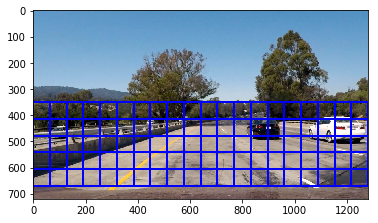

In [5]:

image = mpimg.imread('./test_images/test1.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [13]:
### TODO: Tweak these parameters and see how the results change.

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


/Users/gq/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 10224
6.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9941


/Users/gq/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


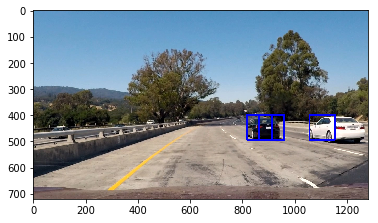

In [8]:

y_start_stop = [350, None] # Min and max in y to search in slide_window()

image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

### 2. Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
#from lesson_functions import *

#dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
#svc = dist_pickle["svc"]
#X_scaler = dist_pickle["scaler"]
#orient = dist_pickle["orient"]
#pix_per_cell = dist_pickle["pix_per_cell"]
#cell_per_block = dist_pickle["cell_per_block"]
#spatial_size = dist_pickle["spatial_size"]
#hist_bins = dist_pickle["hist_bins"]


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    box_list=[]
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # ((x1, y1), (x2, y2))
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return box_list

/Users/gq/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


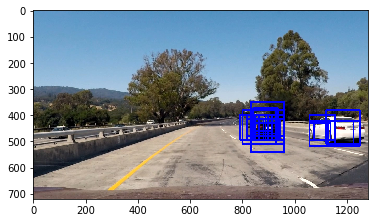

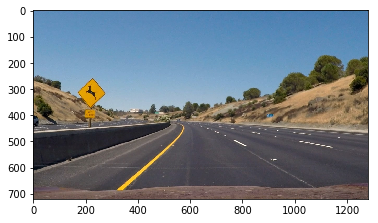

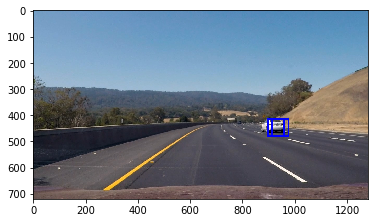

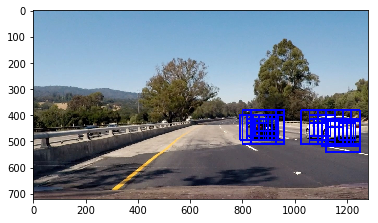

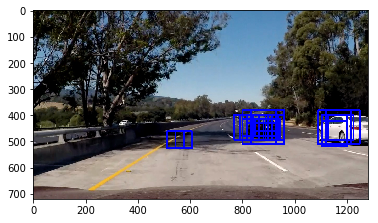

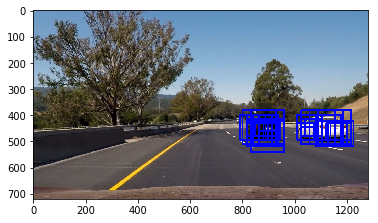

In [14]:
import re

ystart = 350
ystop = 656


images = glob.glob('./test_images/*.jpg')
for image in images:
    img = mpimg.imread(image)
    draw_img = np.copy(img)
    
    scale = 1
    box_list1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale = 1.5
    box_list2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale = 2
    box_list3 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    box_list = box_list1 + box_list2 + box_list3
    
    window_img = draw_boxes(draw_img, box_list, color=(0, 0, 255), thick=6)                    
    
    fig = plt.figure()
    plt.imshow(window_img)
    plt.show()
    
    img_save_path = './output_images/find_car_' + re.split('/', image)[-1]
    fig.savefig(img_save_path)


## Heatmap plot and car location

In [15]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



/Users/gq/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


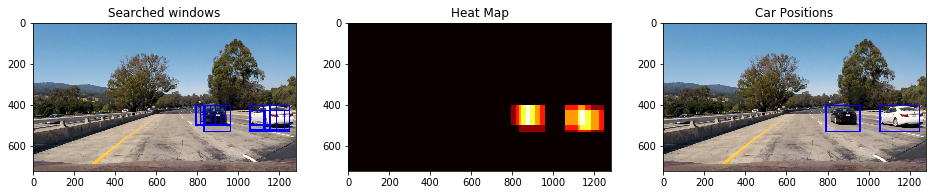

In [ ]:
ystart = 400
ystop = 656


images = glob.glob('./test_images/*.jpg')
for image in images:
    img = mpimg.imread(image)
    draw_img = np.copy(img)
    
    scale = 1
    box_list1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale = 1.5
    box_list2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale = 2
    box_list3 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    box_list = box_list2 + box_list3
    
    window_img = draw_boxes(draw_img, box_list, color=(0, 0, 255), thick=6)                    
    plt.figure(figsize=(16,4))
    plt.subplot(131)
    plt.imshow(window_img)
    plt.title('Searched windows')
    
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    
    plt.subplot(133)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.show()
    
    img_save_path = './output_images/heatmap_and_position_' + re.split('/', image)[-1]
    fig.savefig(img_save_path)
    

## Test on video

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [40]:
def process_image(image):
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 12  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    
    y_start_stop = [400, None] # Min and max in y to search in slide_window()

    draw_image = np.copy(image)
 

    scale = 1
    box_list_1 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 1.5
    box_list_2 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 2
    box_list_3 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #scale = 2.5
    #out_img, box_list_4 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #scale = 3
    #out_img, box_list_5 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #scale = 3.5
    #out_img, box_list_6 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #scale = 4
    #out_img, box_list_7 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    box_list = box_list_1 + box_list_2 + box_list_3
    #+ box_list_4 + box_list_5 + box_list_6 + box_list_7

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img


In [41]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './test_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./test_video_output.mp4
[MoviePy] Writing video ./test_video_output.mp4


 97%|█████████▋| 38/39 [00:55<00:01,  1.47s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output.mp4 

CPU times: user 54.5 s, sys: 1.58 s, total: 56.1 s
Wall time: 56.4 s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [45]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [28:44<00:01,  1.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 28min 8s, sys: 47.5 s, total: 28min 55s
Wall time: 28min 45s


In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))